In [1]:
import os

# os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib:/usr/local/cuda/targets/x86_64-linux/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PT_XLA_DEBUG_FILE'] = './xla_debug.txt'
os.environ['PJRT_DEVICE'] = 'TPU'

# Nonzero op lowering is unstable but seems to work for some ops
# os.environ['XLA_EXPERIMENTAL'] = 'nonzero'

# Will cast torch.float and torch.double to BF16
os.environ['XLA_USE_BF16'] = '1'

os.environ['XLA_EMIT_STEPLOG'] = '1'
# Will cast torch.float to BF16 and torch.double to float32
# os.environ['XLA_DOWNCAST_BF16'] = '1'
os.environ['XLA_IR_DEBUG'] = '1'
os.environ['XLA_HLO_DEBUG'] = '1'
os.environ['MASTER_PORT'] = '29500'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

if xm.get_xla_supported_devices("GPU") is not None:
    print("XLA GPU is available")
elif xm.get_xla_supported_devices("TPU") is not None:
    print("XLA TPU is available:", xm.get_xla_supported_devices("TPU",8))

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2
import time

import torch_xla.debug.profiler as xp
import torch_xla.utils.utils as xu
import multiprocessing
dist.init_process_group('xla', init_method='pjrt://')

# !git clone -b xla https://github.com/drhead/sam-hq.git
# os.chdir('sam-hq')
# !export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.0.0a0+gitc263bd4
XLA TPU is available: ['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']


In [2]:
#!mkdir pretrained_checkpoint
#!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth
#!mv sam_hq_vit_h.pth pretrained_checkpoint


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = anns
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0].shape[0], sorted_anns[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann.cpu()
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [28]:
#image = cv2.imread('data/zd_testimgs/-663378304158021540.webp')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#print(image.shape)
#plt.figure(figsize=(20,20))
#plt.imshow(image)
#plt.axis('off')
#plt.show()

(512, 512, 3)


In [2]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.file_list = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_list[idx])
        image = cv2.imread(img_path)
        print(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image
    
data_directory = "./data/zd_testimgs/"
dataset = CustomImageDataset(data_directory)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [3]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_h.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

<All keys matched successfully>


In [4]:
def gen_masks():
    xp.trace('localhost:6009', logdir='/home/lodestone/sam-hq/', num_tracing_attempts=1, host_tracer_level=3, timeout_s=15, duration_ms=10000)
    print('Done tracing')
trace = False
p = multiprocessing.Process(target=gen_masks)
if trace:
    p.start()
    server = xp.start_server(6009)
    time.sleep(5)

SERIAL_EXEC = xmp.MpSerialExecutor()
def load_dataset():
    return dataloader
    # dataset = CustomImageDataset(path)
    # return DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

def _mp_fn(index, model):
    print(f"Spawned process for index {index}")
    
    model = sam.to(xm.xla_device())
    print(f"Model moved to device on {index}")
    model.eval()
    sam_dynamo = torch.compile(model, backend='torchxla_trace_once')
    print(f"Torch compiled on {index}")
    # pjrt.broadcast_master_param(sam_dynamo)
    mask_generator = SamAutomaticMaskGenerator(
        model=sam_dynamo,
        points_per_side=4,
        points_per_batch=16
    )
    print(f"Model loaded on {index}")
    train_loader = SERIAL_EXEC.run(lambda: load_dataset())
    print(f"Dataset loaded on {index}")
    for batch_idx, (input) in enumerate(train_loader):
        print(f"On device {index}, starting batch {batch_idx}")
        input.numpy()
        for i in range(input.shape[0]):
            masks = mask_generator.generate(input[i, ...], multimask_output=False)
            print(f"On device {index}, batch {batch_idx}, got {masks.shape[0]} masks")
print(__name__)
if __name__ == '__main__':
    xmp.spawn(_mp_fn, args=(sam, ))

__main__


Process SpawnProcess-4:
Traceback (most recent call last):
  File "/home/lodestone/anaconda3/envs/sam_hq_xla/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/lodestone/anaconda3/envs/sam_hq_xla/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lodestone/anaconda3/envs/sam_hq_xla/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/lodestone/anaconda3/envs/sam_hq_xla/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute '_mp_fn' on <module '__main__' (built-in)>
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/home/lodestone/anaconda3/envs/sam_hq_xla/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/lodestone/anaconda3/envs/sam_hq_xla/lib/python3.8/mult

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

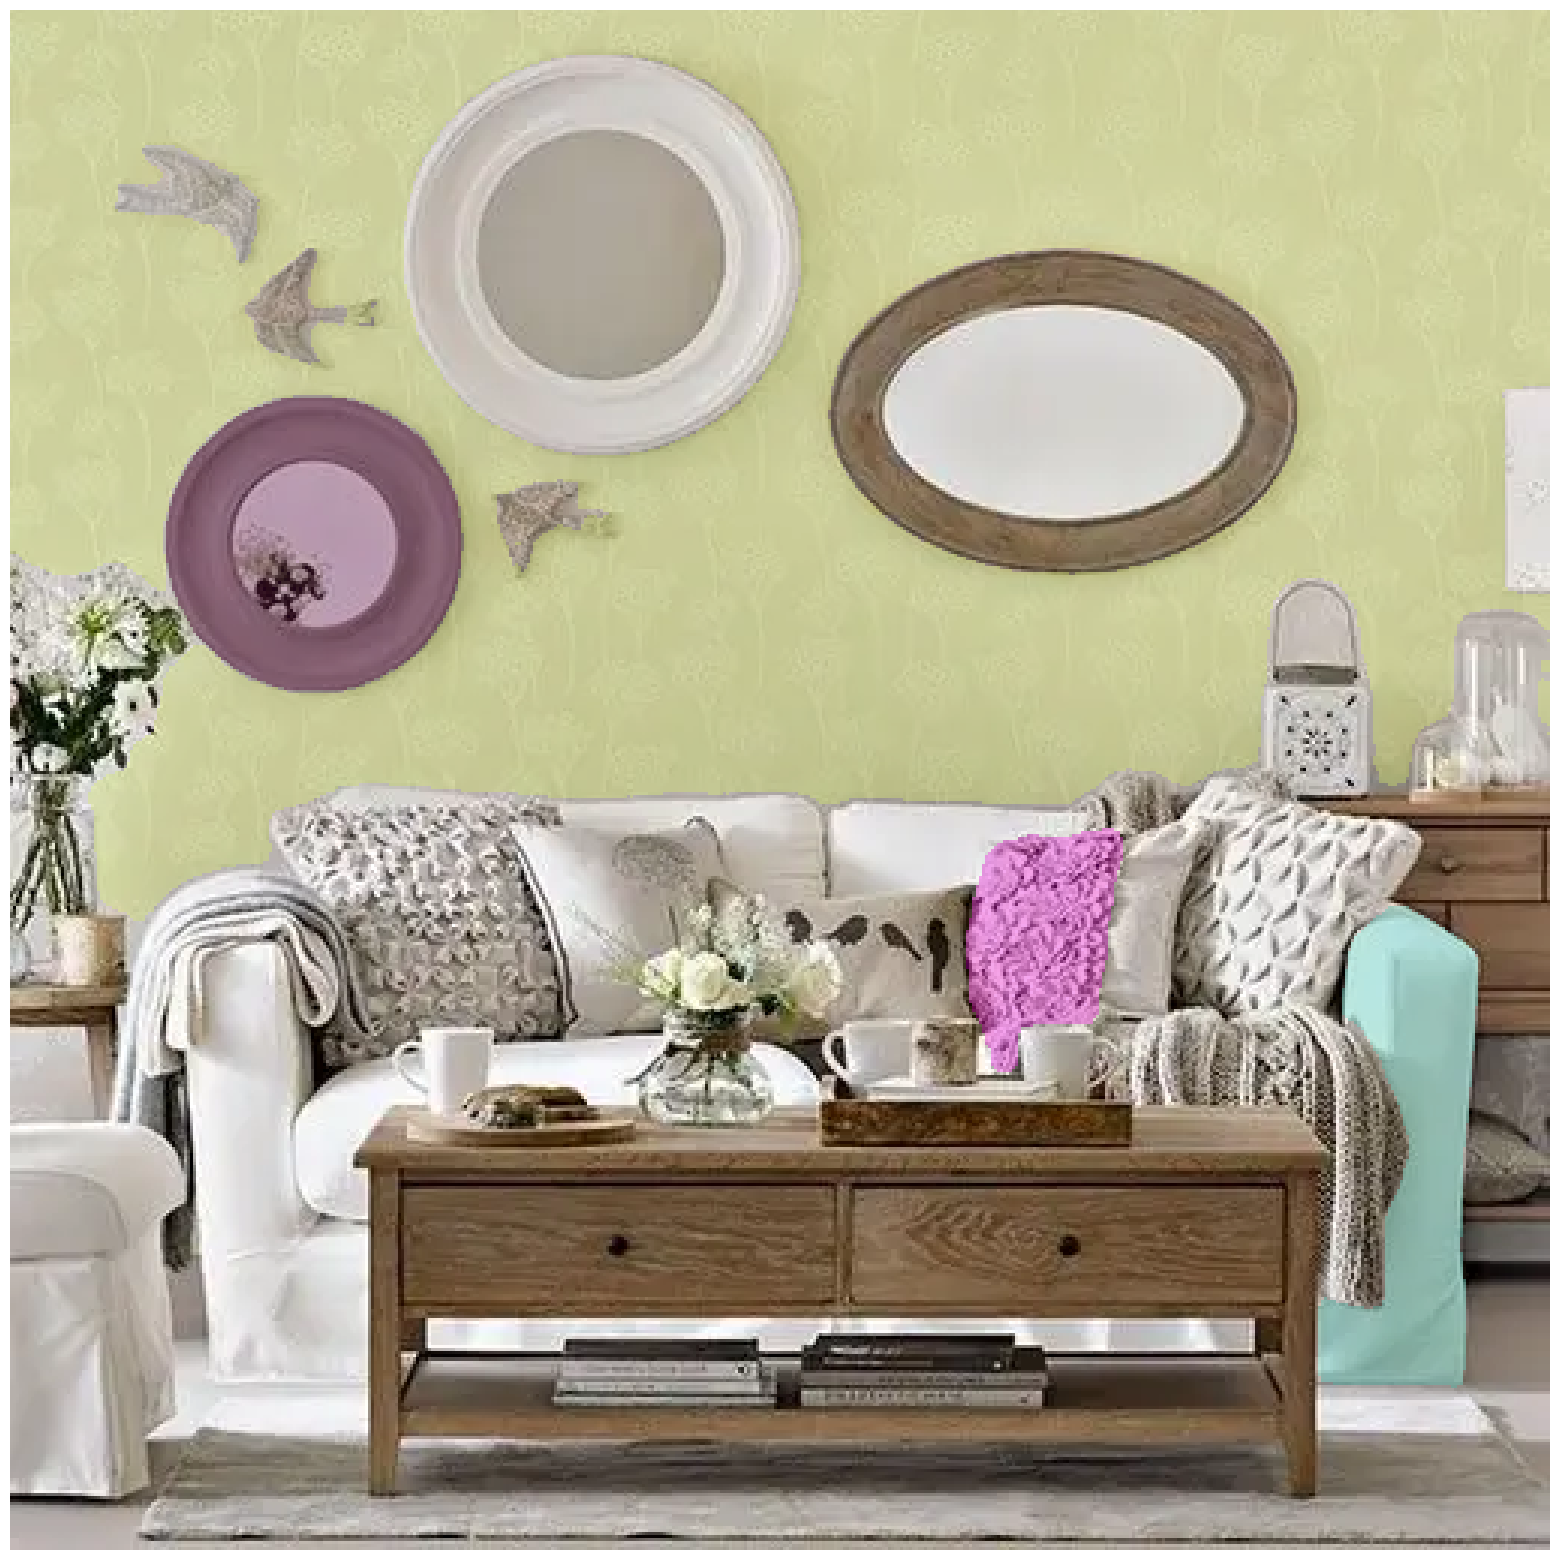

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
import torch_xla.debug.metrics as met
print(met.metrics_report())
met.clear_all()

Metric: DeviceLockWait
  TotalSamples: 90
  Accumulator: 981.048us
  ValueRate: 017.114us / second
  Rate: 1.57005 / second
  Percentiles: 1%=001.795us; 5%=002.031us; 10%=002.221us; 20%=002.381us; 50%=007.271us; 80%=008.610us; 90%=010.044us; 95%=011.581us; 99%=463.383us
Metric: InputOutputAliasCount
  TotalSamples: 2
  Accumulator: 621.00
  ValueRate: 16.38 / second
  Rate: 0.052738 / second
  Percentiles: 1%=0.00; 5%=0.00; 10%=0.00; 20%=0.00; 50%=621.00; 80%=621.00; 90%=621.00; 95%=621.00; 99%=621.00
Metric: IrValueTensorToXlaData
  TotalSamples: 2041
  Accumulator: 02s606ms547.766us
  ValueRate: 005ms152.282us / second
  Rate: 62.9345 / second
  Percentiles: 1%=033.664us; 5%=052.946us; 10%=054.414us; 20%=056.420us; 50%=067.065us; 80%=077.434us; 90%=085.659us; 95%=102.149us; 99%=662.533us
Metric: TensorToData
  TotalSamples: 2060
  Accumulator: 02s594ms022.555us
  ValueRate: 005ms647.596us / second
  Rate: 62.9346 / second
  Percentiles: 1%=032.248us; 5%=046.935us; 10%=048.303us; 20%=